<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML-in-Business_practice/blob/main/ch3_linear-regression/ch3_linear_regression_concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
!wget "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/main/utils.py"

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from utils import display_side_by_side, DataLoader

np.random.seed(3)

Downloading...
From: https://drive.google.com/uc?id=15p2cUU3ocPUDDS9tGmhNos05dSyJFd2A
To: /content/utils.py
100% 7.29k/7.29k [00:00<00:00, 3.25MB/s]


# Linear Regression

In [ ]:
#@title load iowa house price data
iowa_scaled_df = DataLoader.load_data('iowa_reduced_scaled')
iowa_original_df = DataLoader.load_data('iowa_original')

some_numerical_features = iowa_scaled_df.columns[:3]
features = iowa_original_df[some_numerical_features]
target_price = iowa_original_df[['SalePrice']]

In [ ]:
display_side_by_side([features.head(), target_price.head()])

LotArea 
 OverallQual 
 OverallCond 
 
 
 
 
 0 
 8450 
 7 
 5 
 
 
 1 
 9600 
 6 
 8 
 
 
 2 
 11250 
 7 
 5 
 
 
 3 
 9550 
 7 
 5 
 
 
 4 
 14260 
 8 
 5 
 
 
 
 
 
 
 SalePrice 
 
 
 
 
 0 
 208500 
 
 
 1 
 181500 
 
 
 2 
 223500 
 
 
 3 
 140000 
 
 
 4 
 250000

In [ ]:
#@title assign random params of linear model
random_params = np.random.rand(4)
random_params

array([0.5507979 , 0.70814782, 0.29090474, 0.51082761])

In [ ]:
#@title use linear model with random params to predict price
predicted_prices = features @ random_params[:3] + random_params[-1]
predicted_prices.astype(int).head(5)

0    4661
1    5294
2    6203
3    5267
4    7862
dtype: int64

how can we improve the model? => by tuning params => how? <br>
the form is quite like $A\vec{x}=\vec{b}$

In [ ]:
#@title change the notations to Ax=b
A = features.copy()
A['intercept'] = 1
x = random_params
b = target_price['SalePrice']
(A @ x).astype(int).head()

0    4661
1    5294
2    6203
3    5267
4    7862
dtype: int64

how to measure the model's performance? <br>
we use mean squared error here <br>
it sounds make sense, but the proof will be presented later

In [ ]:
#@title compute MSE
costJ = ((A@x - b)**2).mean()
"{:.2E}".format(costJ)

'3.65E+10'

# Normal Equation
by computing $\frac{\partial J}{\partial params} = 0$ <br>
we can find $params = (A^TA)^{-1}A^Tb$

In [ ]:
def find_best_params_minimizing_mse(A, b):
    return (np.linalg.inv(A.T @ A) @ A.T @ b).values

In [ ]:
x_best = find_best_params_minimizing_mse(A, b)
x_best

array([ 2.03456666e+00,  4.40036262e+04, -1.66144479e+03, -9.87832286e+04])

In [ ]:
#@title minimized MSE
minimized_costJ = ((A@x_best - b)**2).mean()
'{:.2E}'.format(minimized_costJ)

'1.88E+09'

In [ ]:
#@title 降低約 94% 的 MSE
round(((minimized_costJ - costJ)/costJ*100), 2)

-94.84

In [ ]:
predictions = pd.DataFrame(A@x_best, columns=['price predicted']).astype(int)
display_side_by_side([predictions.head(), target_price.head()])

,price predicted
0,218127
1,171478
2,223823
3,220365
4,273951
,SalePrice
0,208500
1,181500
2,223500
3,140000


cons:
* if A contains a lot of features, then the overhead of computing the inverse of the matrix would be large.
* if Ax is plugged into some nonlinear function, then we cannot use this method

# R-squared

$Var[y-\bar{y}] = Var[y'-\bar{y}] + Var[y-y']$ <br>
$R-squared = \frac{Var[y'-\bar{y}]}{Var[y-\bar{y}]}$

In [ ]:
mean_price = target_price.values.mean()
total_var = target_price.values.var()
explained_var = (predictions.values - mean_price).var()
r_squared = round(explained_var / total_var, 3)
print(r_squared)

0.692


In [ ]:
def r_squared(y_true, y_predicted):
    return round((y_predicted - y_true.mean()).var() / y_true.var(), 3)

print(r_squared(target_price.values, predictions.values))

0.692


In [ ]:
#@title categorical feature
iowa_original_df['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(iowa_original_df[['Neighborhood']])
onehot_encoded_res = encoder.transform([['Blmngtn'], ['BrDale']])
print(onehot_encoded_res)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


In [ ]:
#@title there's no relation between values
onehot_encoded_res[0] @ onehot_encoded_res[1]

0.0

In [ ]:
#@title categorical feature with natural ordering
# Good, Typical, Excellent, No Bsmt, Fair
iowa_original_df['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', 'NA', 'Fa'], dtype=object)

In [ ]:
def convert_to_natural_ordering(df, cols: list, mapping: dict):
    for col, mapp in zip(cols, mapping):
        df[col] = df[col].replace(mapp)
    return df

cols = ['BsmtQual']
ordering_mapping = [{
    "Ex": 4, "Gd": 3, "TA": 2,
    "Fa": 1, "NA": 0
}]

BsmtQual_df = iowa_original_df[['BsmtQual']].copy()
_ = BsmtQual_df.pipe(convert_to_natural_ordering, cols, ordering_mapping)
display_side_by_side([BsmtQual_df.head(), iowa_original_df[['BsmtQual']].head()])

,BsmtQual
0,3
1,3
2,3
3,2
4,3
,BsmtQual
0,Gd
1,Gd
2,Gd
3,TA


# Dummy Variable Trap

In [ ]:
#@title original features + one hot features
encoder = OneHotEncoder(sparse=False, )
encoder.fit(iowa_original_df[['Neighborhood']])
onehot_features = pd.DataFrame(
    encoder.transform(iowa_original_df[['Neighborhood']]),
    columns=encoder.get_feature_names()
)
A = pd.concat([A, onehot_features], axis=1)
A.head()

,LotArea,OverallQual,OverallCond,intercept,x0_Blmngtn,x0_Blueste,x0_BrDale,x0_BrkSide,x0_ClearCr,x0_CollgCr,x0_Crawfor,x0_Edwards,x0_Gilbert,x0_IDOTRR,x0_MeadowV,x0_Mitchel,x0_NAmes,x0_NPkVill,x0_NWAmes,x0_NoRidge,x0_NridgHt,x0_OldTown,x0_SWISU,x0_Sawyer,x0_SawyerW,x0_Somerst,x0_StoneBr,x0_Timber,x0_Veenker
0,8450,7,5,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9600,6,8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,11250,7,5,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9550,7,5,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14260,8,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def split_df(A, b, bound):
    return (A.iloc[:2000], b.iloc[:2000]),\
           (A.iloc[2000:], b.iloc[2000:])

def params_interpretabilty_score(weights):
    mean_price = iowa_original_df['SalePrice'].mean()
    features = encoder.get_feature_names()
    num_of_features = len(features)
    num_of_features_reasonable = 0

    def sign(p1, p2):
        return 1 if p1 > p2 else -1

    for weight, neighbor in zip(weights[4:], features):
        neighbor_idx = iowa_original_df[(iowa_original_df['Neighborhood'] == neighbor[3:])].index
        neighbor_mean_price = iowa_original_df['SalePrice'].iloc[neighbor_idx].mean()
        if weight * sign(neighbor_mean_price, mean_price) > 0:
            num_of_features_reasonable += 1
    print("interpretability score : {} / {}".format(num_of_features_reasonable, num_of_features))

In [ ]:
#@title find params as usual way
(A_train, b_train), (A_test, b_test) = split_df(A, b, 2000)
x_best = find_best_params_minimizing_mse(A_train, b_train)
print("r-squared: ", r_squared(b_train.values,
                               (A_train @ x_best).values))
display_side_by_side([pd.DataFrame(A_train @ x_best).astype(int).head(),
                      pd.DataFrame(b_train).head()])
params_interpretabilty_score(x_best)

r-squared:  3375.03


,0
0,-554416
1,6196853
2,130325
3,-2876699
4,2663908
,SalePrice
0,208500
1,181500
2,223500
3,140000


interpretability score : 13 / 25


In [ ]:
#@title bias term is highly correlated to the dummy variables
x_best_modified = x_best.copy()
x_best_modified[3] += 9e6
x_best_modified[4:] -= 9e6

print('{:.2E}'.format(((A_train @ x_best)**2).mean()))
print('{:.2E}'.format(((A_train @ x_best_modified)**2).mean()))

3.22E+13
3.22E+13


In [ ]:
#@title find params with no intercept
(A_train, b_train), (A_test, b_test) = \
                split_df(A.drop('intercept', axis=1), b, 2000)
x_best = find_best_params_minimizing_mse(A_train, b_train)
print("r-squared train: ", r_squared(b_train.values,
                                     (A_train @ x_best).values))
print("r-squared  test: ", r_squared(b_test.values,
                                    (A_test @ x_best).values))
display_side_by_side([pd.DataFrame(A_train @ x_best).astype(int).head(),
                      pd.DataFrame(b_train).head()])
params_interpretabilty_score(x_best)

r-squared train:  0.754
r-squared  test:  0.694


,0
0,208601
1,205375
2,212553
3,226513
4,317000
,SalePrice
0,208500
1,181500
2,223500
3,140000


interpretability score : 15 / 25


In [ ]:
#@title find params with no intercept and get rid of one dummy
(A_train, b_train), (A_test, b_test) = \
            split_df(A.drop(['intercept', 'x0_Veenker'], axis=1), b, 2000)
x_best = find_best_params_minimizing_mse(A_train, b_train)
print("r-squared train: ", r_squared(b_train.values,
                                     (A_train @ x_best).values))
print("r-squared  test: ", r_squared(b_test.values,
                                    (A_test @ x_best).values))
display_side_by_side([pd.DataFrame(A_train @ x_best).astype(int).head(),
                      pd.DataFrame(b_train).head()])
params_interpretabilty_score(x_best)

r-squared train:  0.748
r-squared  test:  0.691


,0
0,208535
1,218126
2,212432
3,226805
4,316976
,SalePrice
0,208500
1,181500
2,223500
3,140000


interpretability score : 15 / 25


# Regularization

$Y = a + 1000X_{1} - 360X_{2}$ -------- 1 <br>
$X_{1} = 0.4X_{2} + \epsilon$ <br>
$Y = a + 1000(0.4X_{2} + \epsilon) - 360X_{2} = a + 40X_{2} + 1000\epsilon$ -------- 2 <br>
$\epsilon$ can be interpreted by $X_{1}$ to some extent <br>
assume that $Y = a + 3X_1 + 40X_{2} + 1000\epsilon'$ where $\epsilon' < \epsilon$<br>
=> $X_{2} \propto Y$ <br>
given a sample of test data i <br>
$(x_1^i, x_2^i) = (0.4, 2)$

1 --- $Y = a - 320$ <br>
2 --- $Y = a + 80$ <br>


if $X_{1}, X_{2}$ are correlated to some extent, then the weights can be smaller without increasing too much prediction err,
<br> while keeping the params' interpretability

how to decrease the value of weights? <br>
>intuition: <br>
add params itself to the cost function
>>$J^{'} = J + \lambda \sum params^2$ (Ridge Regression)

We can still minimize this by the Normal Equation <br>
$params = (A^TA + \lambda I)^{-1}A^Tb$

In [ ]:
def find_best_params_with_reg_minimizing_mse(A, b, lam):
    return (np.linalg.inv(A.T @ A + lam*np.identity(A.shape[1])) @ A.T @ b).values

In [ ]:
(A_train, b_train), (A_test, b_test) = split_df(A, b, 2000)
x_best_regularized = find_best_params_with_reg_minimizing_mse(A_train, b_train, 0.01)

print("r-squared train: ", r_squared(b_train.values,
                                     (A_train @ x_best_regularized).values))
print("r-squared  test: ", r_squared(b_test.values,
                                    (A_test @ x_best_regularized).values))

display_side_by_side([pd.DataFrame(A_train @ x_best_regularized).astype(int).head(),
                      pd.DataFrame(b_train).head()])
params_interpretabilty_score(x_best_regularized)

r-squared train:  0.754
r-squared  test:  0.694


,0
0,208601
1,205353
2,212554
3,226514
4,316988
,SalePrice
0,208500
1,181500
2,223500
3,140000


interpretability score : 21 / 25


In [ ]:
#@title fit with no dummy, compare no reg & reg
A = iowa_original_df[some_numerical_features].copy()
A['intercept'] = 1
b = target_price['SalePrice']

(A_train, b_train), (A_test, b_test) = split_df(A, b, 2000)
x_best = find_best_params_minimizing_mse(A_train, b_train)
x_best_regularized = find_best_params_with_reg_minimizing_mse(A_train, b_train, 0.01)

def cal_mse(predicted, y_true):
    return round(((predicted.values - y_true.values)**2).sum()/len(y_true.values), 2)

In [ ]:
#@markdown on train set : without reg train mse < reg train mse <br>
#@markdown on  test set : without reg test mse > reg test mse

print("training without regularization")
print("train mse :", cal_mse(A_train @ x_best, b_train),
      "r_squared :", r_squared(b_train.values, (A_train @ x_best).values))

print("test mse :", cal_mse(A_test @ x_best, b_test),
      "r_squared :", r_squared(b_test.values, (A_test @ x_best).values), '\n')

print("training with regularization")
print("train mse :", cal_mse(A_train @ x_best_regularized, b_train), 
      "r_squared :", r_squared(b_train.values, (A_train @ x_best_regularized).values))

print("test mse :", cal_mse(A_test @ x_best_regularized, b_test), 
      "r_squared :", r_squared(b_test.values, (A_test @ x_best_regularized).values), '\n')

training without regularization
train mse : 1897374310.3 r_squared : 0.687
test mse : 1866015802.21 r_squared : 0.659 

training with regularization
train mse : 1897374323.65 r_squared : 0.687
test mse : 1866009041.87 r_squared : 0.659 



In [ ]:
#@title the output is similar in this data
display_side_by_side([pd.DataFrame(A_train @ x_best).astype(int).head(),
                      pd.DataFrame(A_train @ x_best_regularized).astype(int).head(),
                      pd.DataFrame(b_train).head()])

,0
0,218093
1,172530
2,222931
3,219994
4,272290
,0
0,218093
1,172525
2,222931
3,219994


In [ ]:
#@title load age_salary data
train_set, val_set, test_set =\
    [DataLoader.load_data('age_salary_url', sheet_name=tgt)
     for tgt in ['train', 'val', 'test']]

In [ ]:
def get_poly(x, y, deg: int):
    weights = np.polyfit(x=x, y=y, deg=deg)
    return np.poly1d(weights)

def get_rmse(x, y, p):
    return int(np.sqrt(mean_squared_error(y_true=y, y_pred=p(x))))

In [ ]:
#@title ploynomial linear model with intercept
x_train, y_train = train_set.Age, train_set.Salary
x_val, y_val = val_set.Age, val_set.Salary
x_train = pd.DataFrame([(x_train.values)**i for i in range(1, 6)]).T.values
x_train = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=1)
x_val = pd.DataFrame([(x_val.values)**i for i in range(1, 6)]).T.values
x_val = np.append(x_val, np.ones((x_val.shape[0], 1)), axis=1)

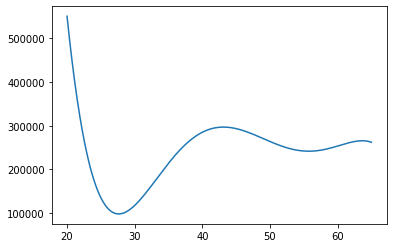


train mse :  12240
  val mse :  36832


In [ ]:
#@title five degree polynomial fit without reg
poly = get_poly(x_train[:, 0], y_train, deg=5)
x = np.linspace(20, 65, 1000)
plt.plot(x, [poly(v) for v in x])
plt.show()

print()
print("train mse : ", get_rmse(x_train[:, 0], y_train, poly))
print("  val mse : ", get_rmse(x_val[:, 0], y_val, poly))

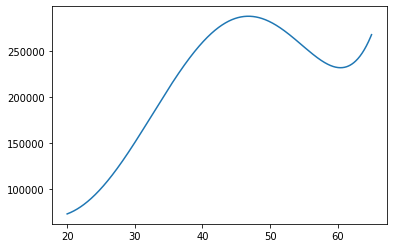


train mse :  24154
  val mse :  35251


In [ ]:
#@title five degree polynomial fit with reg
#@markdown another way to control model complexity
weights = find_best_params_with_reg_minimizing_mse(pd.DataFrame(x_train), y_train, lam=0.2)
poly = np.poly1d(np.append(weights[:5][::-1], weights[-1]))
x = np.linspace(20, 65, 1000)
plt.plot(x, [poly(v) for v in x])
plt.show()

print()
print("train mse : ", get_rmse(x_train[:, 0], y_train, poly))
print("  val mse : ", get_rmse(x_val[:, 0], y_val, poly))

# Logistic Regression
$h(y_i|x_i,m,\theta)$ 的值域: $(-\infty, \infty)$<br>
label值: {0, 1}<br>
要預測個別class(2個)的機率, 設 $\pi$ 為 label 1 的機率<br>
Bernoulli pmf: $Ber(y_i|\pi) = \pi^{y_i}(1-\pi)^{(1-y_i)}$<br>
$\pi$ 的值域: [0, 1], 跟 h 不一樣<br>
令$\mu_i = E_{y_i \sim Ber(y_i|\pi)}[y_i] = \pi$ 為 mean parameter <br>
$g(\mu_i) = h(y_i|x_i,m,\theta)$ <br>
$g$ 要能使 $g(\mu_i)$ 的值域和 $h$ 相同 <br>
$g^{-1}$ 要能使 $g^{-1}(h(y_i|x_i,m,\theta))$ 的值域和 $\mu_i$ 相同<br>

$exponential family:$<br>
>$p(y|\eta) = h(y)exp(\eta^T T(y)-A(\eta))$<br>
$\int p(y|\eta)dy = 1$<br> 
$A(\eta) = ln(\int h(y)exp(\eta^T T(y))dy)$ <br><br> 
$\frac{\partial A(\eta)}{\partial \eta}$ <br> 
>>$=\frac{\int h(y)exp(\eta^T T(y))T(y)dy}{exp(A(\eta))}$ <br> 
$= \int p(y|\eta)T(y)dy$<br> 
$= E_y[T(y)]$ <br><br>

$Ber(y_i|\pi)$
>$= exp(ln(\pi^{y_i}(1-\pi)^{(1-y_i)}))$ <br>
$= exp(y_i ln(\frac{\pi}{1-\pi}) + ln(1-\pi))$ <br>

$A(\eta) = -ln(1-\pi) = ln(1+e^\eta)$ <br><br>
$\frac{\partial A(\eta)}{\partial \eta} = \frac{e^\eta}{1+e^\eta} = \frac{1}{1+e^{-\eta}} = sigmoid(\eta) = \pi = g^{-1}(h) = g^{-1}(\eta)$ <br>

$g^{-1} = sigmoid = \sigma$

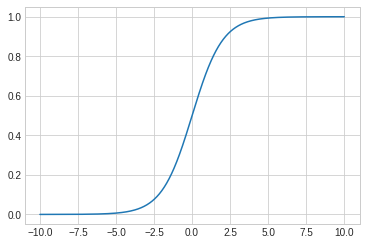

In [ ]:
def sigmoid(x):
    return 1/(1+np.e**-x)

plt.style.use('seaborn-whitegrid')

x = np.linspace(-10, 10, 1000)
plt.plot(x, [sigmoid(v) for v in x])
plt.show()

what's our loss function? <br>

預測越準，$Ber(y_i|g^{-1}(h))$ 的值越高 <br>
希望能將 summation over all i 最大化

$D: dataset, m: hyper parameters, \theta: weights$ <br>
$x_i: features, y_i: label, y_i: prediction$

$\theta_{MLE}$

>$= argmax_{\theta} [p(D|m,\theta)]$<br>
$= argmax_{\theta} \prod_i p(d_i|m,\theta)$<br>
$= argmax_{\theta} \sum_i ln(p(d_i|m,\theta))$<br>
$= argmax_{\theta} \sum_i ln(p(x_i, y_i|m,\theta))$<br>
$= argmax_{\theta} \sum_i ln(p(y_i|x_i,m,\theta) p(x_i|m,\theta))$<br>
$= argmax_{\theta} \sum_i ln(p(y_i|x_i,m,\theta) p(x_i))$<br>
$= argmax_{\theta} \sum_i ln(p(y_i|x_i,m,\theta))$<br>
$= argmin_{\theta} \frac{1}{N} \sum_i -ln(p(y_i|x_i,m,\theta))$<br>
$= argmin_{\theta} \frac{1}{\sqrt{2\pi}} \sum_i -ln(p(y_i|x_i,m,\theta))$<br>
$= argmin_{\theta} E_{y_i \sim p_{data}}[-ln(p_{model}(y_i|x_i,m,\theta))]$

$p = t_{n}^{y_{n}}(1-t_{n})^{1 - y^n}$ <br>
$\theta_{MLE} = argmin_{\theta} -\sum_{n=1}^N y_{n}ln(t_{n}) + (1 - y_n)ln(1-t_n)$ <br>
$Loss = \sum_{n=1}^N -y_{n}ln(t_{n}) - (1 - y_n)ln(1-t_n)$

how to find the best params? => how to minimize Loss by finding the $\theta$? <br>
we cannot solve this analytically because the ouput of the linear function is plugged into the non-linear function sigmoid <br>
we can only use iterative method like 'gradient descent'

# Regression loss function: squared error 推導

$p_{model}(y_i|x_i,m,\theta)$
>$= \frac{1}{\sqrt{2\pi}\sigma} exp(\frac{-1}{2\sigma^2}(y_i - y_i')^2)$<br>
$= \frac{1}{\sqrt{2\pi}\sigma} exp(\frac{-1}{2\sigma^2}(y_i - h(x_i,m,\theta))^2)$

$\theta_{MLE}$
>$= argmax_{\theta} \sum_i ln(\frac{1}{\sqrt{2\pi}\sigma}) - \frac{1}{2\sigma^2}(y_i - h(x_i,m,\theta))^2)$ <br><br>
$\sigma^2$ 為 error 的 variance, 令 $\sigma^2=1$ 不影響找到的參數 $\theta$ <br><br>
$= argmax_{\theta} \sum_i - \frac{1}{2}(y_i - h(x_i,m,\theta))^2)$ <br>
$= argmin_{\theta} \sum_i \frac{1}{2}(y_i - h(x_i,m,\theta))^2)$ <br>
$= argmin_{\theta} \sum_i \frac{1}{2N}(y_i - h(x_i,m,\theta))^2)$

# Regularization 推導

$\theta_{MAP}$
>$= argmax_\theta p(\theta|D,m)$<br>
$= argmax_\theta \frac{p(D,m|\theta)p(\theta)}{p(D,m)}$<br>
$= argmax_\theta \frac{p(D|m,\theta)p(\theta|m)}{p(D|m)}$<br>
$= argmax_\theta \sum_i[ln(p(y_i|x_i,m,\theta)] + ln(p(\theta|m))$<br>

$p(\theta|m) = \frac{1}{\sqrt{2\pi}\sigma}exp(\frac{-1}{2\sigma^2}\theta^2)$

$\theta_{MAP}$
>$= argmax_\theta \sum_i[ln(p(y_i|x_i,m,\theta)] - \frac{1}{2\sigma^2}\theta^2$<br>
$= argmin_\theta \sum_i[-ln(p(y_i|x_i,m,\theta)] + \frac{1}{2\sigma^2}\theta^2$ ------ ridge <br>

laplace : $\frac{1}{2b}exp(-\frac{|x-\mu|}{b})$, $p(\theta|m) = \frac{1}{2b}exp(-\frac{|\theta|}{b})$ <br>
$\theta_{MAP}$
>$ = argmin_\theta \sum_i[-ln(p(y_i|x_i,m,\theta)] + \frac{1}{b}|\theta|$ ------ lasso

# k-nearest

In [ ]:
train_set = DataLoader.load_data('lending_club_reduced_train_url')
test_set = DataLoader.load_data('lending_club_reduced_test_url')
train_set.head()

,home_ownership,income,dti,fico_low,loan_status
0,1,44.304,18.47,690,0
1,0,38.500,33.73,660,0
2,1,54.000,19.00,660,0
3,1,60.000,33.98,695,0
4,0,39.354,10.85,685,0


In [ ]:
x_train = train_set.iloc[:, :4]
y_train = train_set.iloc[:, -1]
x_test = test_set.iloc[:, :4]
y_test = test_set.iloc[:, -1]
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns=x_test.columns)
x_train.head()

,home_ownership,income,dti,fico_low
0,0.831250,-0.581419,-0.061604,-0.149476
1,-1.203008,-0.681950,0.839871,-1.136586
2,0.831250,-0.413476,-0.030294,-1.136586
3,0.831250,-0.309550,0.854639,0.015042
4,-1.203008,-0.667157,-0.511750,-0.313994


In [ ]:
def predict(sample, k=10):
    top_k_idx = ((x_train-sample)**2).sum(axis=1).nsmallest(k).index
    return y_train.iloc[top_k_idx].values.sum()/k

In [ ]:
predictions = x_test.apply(predict, axis=1)

In [ ]:
predictions

0       0.8
1       0.9
2       0.7
3       1.0
4       0.8
       ... 
5911    0.8
5912    0.8
5913    0.6
5914    0.7
5915    0.6
Length: 5916, dtype: float64

In [ ]:
round(roc_auc_score(y_test, predictions), 3)

0.558